<a href="https://colab.research.google.com/github/Phund4Bot/DZ/blob/main/01_spark_rdd_bauman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark

## Недостатки MapReduce
1) **Минимум 2 итерации записи на HDD** за job'у => не работает в реальном времени. Хотелось бы хранить сплиты в RAM.

2) Нужно писать **очень много кода** (вспоминаем задачу с WordCount).

3) По сути 1 источник данных - диск (HDFS, локальная ФС клиента... но всё равно диск). Хотелось бы уметь читать / писать в другие источники (базы данных, облачные хранилища).

**Итог:** с MapReduce **можно** работать с BigData, но нельзя работать быстро.

* **200Х годы**: нам нужна отказоустойчивая система. RAM на серверах мало. Будем сохранять промежуточные данные **на диск**.
* **201Х годы**:
    - Память становится дешевле и больше.
    - Запросы от бизнеса на максимально быструю обработку (real-time).

Диск использовать нецелесообразно - обращаемся к RAM.

## Составляющие Spark-экосистемы

Spark Написан на Scala, имеет Scala, Java, Python API.

1. Spark Core - разбор кода, распределённое выполнение, поддержка отказоустойчивости.
2. Аналог "стандартной библиотеки":
   * Spark SQL - высокоуровненвая обработка с помощью pandas-подобного синтаксиса или SQL.
   * Spark Streaming, Spark Structured Streaming - обработка (обновление результатов) данных в real-time
   * MLLib - инструментарий для ML. Помимо Spark использует сторонние библиотеки (например Breeze, написанный на Fortran).
3. Планировщики:
   * Standalone - легковесный Spark на 1 машине. Использует встроенный планировщик
   * Может использовать другие планировщики (например YARN).

Подробнее **[здесь](https://www.oreilly.com/library/view/learning-spark/9781449359034/ch01.html)**.

#### Источники данных

В теории можем читать-писать в большое кол-во источников и приёмников данных.

На практике:
* Есть проблемы при взаимодействии с Hive,
* И при подключении к Cassandra.
* Хорошо взаимодействует с Kafka.

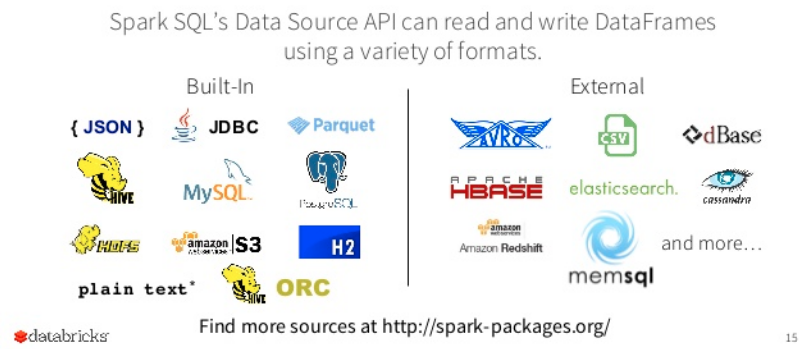

In [12]:
from IPython.display import Image
Image(filename='datasources.png')

In [25]:
! ls

cluster-overview.png  content  datasources.png	sample_data  stages.png


## Архитектура Spark-приложения
![Image](images/cluster-overview.png)
(https://spark.apache.org/docs/latest/cluster-overview.html)

1. Driver program - управляющая программа.
2. SparkContext - это основной объект, с помощью которого мы взаимодействуем со Spark.
3. Cluster manager - планировщик (любой, см. выше).
4. Executor - по сути JVM на нодах.

В 1-м приближении работает также как и Hadoop. Единственное, контейнеры **долго живущие**. Контейнеры поднимаются 1 раз и умирают когда заканчивается SparkContext. Это позволяет хранить данные **в памяти JVM**.

## Возможности работы со Spark
##### Интерактивный shell

1. `spark-shell` - запускает Scala-оболочку.
2. `pyspark` - python оболочку.

В этих оболочках уже имеется готовый SparkContext (переменная `sc`).

##### Запуск файла на исполнение
`spark-submit <file>` - можем запускать как jar-файлы, так и коды на Python.


#### Режимы запуска Spark
1. **local**. И драйвер, и worker стартуют на 1 машине. Можно указывать число ядер, выделенных на задачу. Например, `local[3]`. Указывать меньше 2 не рекомендуется т.к. всегда запускает 2 процесса: driver, worker.
2. **yarn**. Распределённый режим. Здесь можно дополнительно указать `--deploy-mode`.
   * `cluster`. Драйвер на мастере или на любой ноде. Рекомендуется для прода.
   * `client`. Драйвер на клиенте. Проще отлаживаться. Проще работать в интерактивном режиме (сейчас мы работаем в режиме `client`). Но грузит клиент.

В аргументах PySpark можно указывать и многе другое, подробнее [здесь](http://spark.apache.org/docs/latest/configuration.html#application-properties).

In [15]:
! pip install pyspark

In [16]:
import pyspark
sc = pyspark.SparkContext()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-5-1974c4bb7055>:2 

In [17]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

Можем изменить конфигурацию SparkContext, правда его придётся перезапустить.

In [26]:
! pwd

/content


## Resilient Distributed Dataset и ленивые вычисления

RDD - набор данных, распределённый по партициям (аналог сплитов в Hadoop). Основной примитив работы в Spark.

##### Свойства
* Неизменяемый. Можем получить либо новый RDD, либо plain object
* Итерируемый. Можем делать обход RDD
* Восстанавливаемый. Каждая партиция помнит как она была получена (часть графа вычислений) и при утере может быть восстановлена.

Создать RDD можно:
* прочитав данные из источника
* получить новый RDD из существующего.

In [50]:
rdd = sc.textFile("./content/griboedov")

In [51]:
rdd.take(5)

['Репетилов\tAx! Alexandre! у нас тебя недоставало;',
 'Репетилов\tПослушай, миленький, потешь меня хоть мало;',
 'Репетилов\tПоедем-ка сейчас; мы, благо, на ходу;',
 'Репетилов\tС какими я тебя сведу',
 'Репетилов\tЛюдьми!!... Уж на меня нисколько не похожи!']

In [35]:
def f(x):
    return x * x
    f(2)

In [36]:
a = lambda x: x * x
a(2)

4

In [52]:
rdd1 = rdd.map(lambda x: x.strip())

In [53]:
rdd1.take(5)

['Репетилов\tAx! Alexandre! у нас тебя недоставало;',
 'Репетилов\tПослушай, миленький, потешь меня хоть мало;',
 'Репетилов\tПоедем-ка сейчас; мы, благо, на ходу;',
 'Репетилов\tС какими я тебя сведу',
 'Репетилов\tЛюдьми!!... Уж на меня нисколько не похожи!']

Посчитаем кол-во объектов в RDD

In [54]:
rdd1.count()

2681


В Spark'е сть 2 типа операций над RDD:
* [трансформации](https://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations). Преобразуют RDD в новое RDD.
* [действия](https://spark.apache.org/docs/latest/rdd-programming-guide.html#actions). Преобразуют RDD в обычный объект.

Трансформации выполяются **лениво**. При вызове трансформации достраивается граф вычислений и больше ничего не происходит.

Реальное выполнение графа происходит при вызове Action.

## WordCount на Spark

Мы уже прочитали данные, теперь попробуем посчитать на них WordCount.

In [55]:
! ls

cluster-overview.png  content  datasources.png	sample_data  stages.png


In [56]:
from pyspark.storagelevel import StorageLevel


In [57]:
rdd = sc.textFile("./content/griboedov")

# строим граф вычислений
rdd = rdd.map(lambda x: x.strip().lower()) # приводим к нижнему регистру
rdd = rdd.flatMap(lambda x: x.split(" ")) # выделяем слова
rdd = rdd.map(lambda x: (x, 1))  # собираем пары (word, 1)
rdd = rdd.reduceByKey(lambda a, b: a + b) # суммируем "1" с одинаковыми ключами
rdd = rdd.sortBy(lambda a: a[1], ascending=False) # сортируем по кол-ву встречаемости

In [58]:
rdd.take(10) # Action!

[('', 432),
 ('в', 344),
 ('-', 296),
 ('и', 295),
 ('не', 287),
 ('я', 139),
 ('с', 129),
 ('на', 126),
 ('что', 104),
 ('*', 94)]

### Типы трансформаций в Spark


* Часть трансформаций (map, flatmap, ...) обрабатывает партиции независимо. Такие трансформации называются *narrow*.
* reduce, sortdBy аггрегируют данные и используют передачу по сети. Они называются *wide*.
   * Wide-трансформации могут менять кол-во партиций.
   * По wide-трансформациям происходит деление job'ы на Stages.

Stage тоже делится на task'и. 1 task выполняется для одной партиции.

**Итак: Task << Stage << Job << Aplication.**

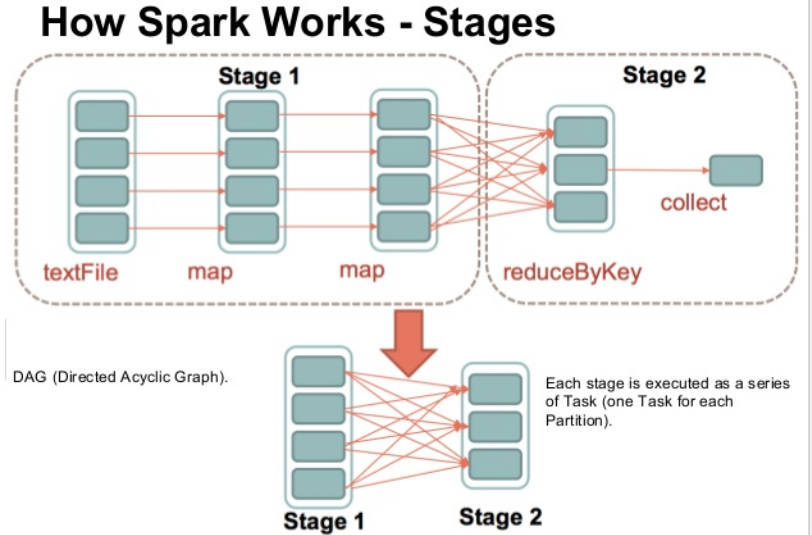

In [ ]:
from IPython.display import Image
Image(filename='stages.png')

В Spark есть возможность вывести план job'ы.

In [ ]:
print(rdd.toDebugString().decode('utf-8'))

(3) PythonRDD[93] at RDD at PythonRDD.scala:53 []
 |  MapPartitionsRDD[91] at mapPartitions at PythonRDD.scala:145 []
 |  ShuffledRDD[90] at partitionBy at NativeMethodAccessorImpl.java:0 []
 +-(3) PairwiseRDD[89] at sortBy at <timed exec>:6 []
    |  PythonRDD[88] at sortBy at <timed exec>:6 []
    |  MapPartitionsRDD[85] at mapPartitions at PythonRDD.scala:145 []
    |  ShuffledRDD[84] at partitionBy at NativeMethodAccessorImpl.java:0 []
    +-(3) PairwiseRDD[83] at reduceByKey at <timed exec>:5 []
       |  PythonRDD[82] at reduceByKey at <timed exec>:5 []
       |  /content/griboedov MapPartitionsRDD[80] at textFile at NativeMethodAccessorImpl.java:0 []
       |  /content/griboedov HadoopRDD[79] at textFile at NativeMethodAccessorImpl.java:0 []


Видим всего 3 трансформации. Где все остальные?

Spark написан на Scala, которая под капотом использует JVM. Чтоб делать вычисления в Python, нужно вытаскивать данные из JVM. А потом возвращаться обратно. Получаем OverHead на сериализацию-десериализацию. Чтоб overhead'ов было меньше, схлопываем узкие трансформации в одну.

In [116]:
import re

rdd = sc.textFile("./content/griboedov")

# строим граф вычислений
rdd = rdd.map(lambda x: re.sub(u"\\W+", " ", x.strip(), flags=re.U).lower()) # удаление пунктуации и приведение к нижнему регистру
rdd = rdd.flatMap(lambda x: x.split(" ")) # разделение текста на слова
rdd = rdd.filter(lambda x: len(x) >= 3) # отфильтровываем слова короче 3 символов
rdd = rdd.map(lambda x: (x, 1))  # собираем пары (word, 1)
rdd = rdd.reduceByKey(lambda a, b: a + b) # суммируем "1" с одинаковыми ключами
rdd = rdd.sortBy(lambda a: a[1], ascending=False) # сортируем по кол-ву встречаемости

rdd.take(10)

[('чацкий', 734),
 ('фамусов', 477),
 ('софия', 294),
 ('примечания', 218),
 ('репетилов', 188),
 ('что', 184),
 ('лиза', 165),
 ('как', 143),
 ('молчалин', 137),
 ('все', 99)]

### Задача 1.

> При подсчёте отсеять пунктуацию и слова короче 3 символов.
При фильтрации можно использовать регулярку: `re.sub(u"\\W+", " ", x.strip(), flags=re.U)`.

### Задача 2.

> Считать только имена собственные. Именами собственными в данном случае будем считать такие слова, у которых 1-я буква заглавная, остальные - прописные.


In [117]:
rdd = sc.textFile('./content/griboedov')

def is_title(word):
    return word.istitle()

rdd = rdd.flatMap(lambda x: x.split(" ")) # выделяем слова
rdd = rdd.map(lambda x: re.sub(u"\\W+", "", x.strip(), flags=re.U)) # убираем знаки
rdd = rdd.filter(is_title)
rdd = rdd.map(lambda x: (x, 1))  # собираем пары (word, 1)
rdd = rdd.reduceByKey(lambda a, b: a + b) # суммируем "1" с одинаковыми ключами
rdd = rdd.sortBy(lambda a: a[1], ascending=False) # сортируем по кол-ву встречаемости

rdd.count()

305

In [75]:
double = lambda x: x*2
print(double(5))

10


In [76]:
def defined_cube(y):
    return y*y*y


lambda_cube = lambda y: y*y*y
print(defined_cube(2))
print(lambda_cube(2))

8
8


In [88]:
import re

rdd = sc.textFile("./content/griboedov")
rdd2 = rdd.map(lambda x: x.strip().lower())
rdd3 = rdd2.flatMap(lambda x: x.split(" "))
rdd4 = rdd3.map(lambda x: (x,1))
rdd5 = rdd4.reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda a: -a[1])

words_count = rdd5.take(10)
for word, count in words_count:
    print(word + " " + str(count))





 432
в 344
- 296
и 295
не 287
я 139
с 129
на 126
что 104
* 94


In [87]:
import re

import sys
if sys.version_info[0] >= 3:
    unicode = str


## Аккумуляторы

Аналоги счётчиков в Hadoop.
* Используется для легковесной аггрегации (без `reduceByKey` и дополнительных shuffle'ов)
* Если аккумулятор используется в трансформациях, то нельзя гарантировать консистентность. Можно использовать в `foreach()`.

**Объявление:** `cnt = sc.accumulator(start_val)`

**Использование:**
   * Inline: `foreach(lambda x: cnt.add(x))`
   * Или же, с помощью своей функции:
    ```python
    def count_with_conditions(x):
    global cnt
    if ...:
        cnt += 1

    rdd.foreach(lambda x: count_with_conditions(x))
    ```

**Получение результата:** `cnt.value`

Подробнее в [документации](http://spark.apache.org/docs/latest/rdd-programming-guide.html#accumulators).

In [ ]:
data = [1, 2, 3, 4, 5]
distData = sc.parallelize(data, 5)

In [ ]:
distData.take(10)

[1, 2, 3, 4, 5]

In [ ]:
distData.getNumPartitions()

5

### Задача 3.

> Переделайте задача 2 так, чтоб кол-во имён собственных вычислялось с помощью аккумулятора.


In [113]:
rdd = sc.textFile("./content/griboedov")
num = sc.accumulator(0)

def count_title(word):
    global num
    if word.istitle():
        num += 1
    return word

rdd = rdd.map(count_title)

rdd.collect()

print("Количество имен собственных:", num.value)


Количество имен собственных: 73


## Кеширование

При перезапуске Action, пересчитывается весь граф вычислений. Это логично т.к. в трансформациях ничего не вычисляется. Полезно это тем, что если за время работы задачи данные обновились (дополнились), нам достаточно просто перевызвать Action.

Но если данные не меняются (например, при отладке), такой пересчёт даёт Overhead. Можно **закешировать** часть pipeline. Тогда при след. вызове Action, RDD считается с кеша и пересчёт начнётся с того места, где было кеширование. В History UI все Stage перед этим будут помечены "Skipped".

In [ ]:
%%time

rdd.unpersist()
rdd = sc.textFile("/content/griboedov")
rdd = rdd.map(lambda x: x.strip().lower())
rdd = rdd.flatMap(lambda x: x.split(" "))
rdd = rdd.map(lambda x: (x, 1)) # тут всё хорошо работает, кешируем
rdd = rdd.reduceByKey(lambda a, b: a + b).cache() # а тут хотим отладить, поэтому будут перезапуски
rdd = rdd.sortBy(lambda a: -a[1])
rdd.take(5)

CPU times: user 54.7 ms, sys: 4.45 ms, total: 59.1 ms
Wall time: 3.56 s


[('', 432), ('в', 344), ('-', 296), ('и', 295), ('не', 287)]

In [ ]:
%%time

rdd = sc.textFile("/content/griboedov")
rdd = rdd.map(lambda x: x.strip().lower())
rdd = rdd.flatMap(lambda x: x.split(" "))
rdd = rdd.map(lambda x: (x, 1)) # тут всё хорошо работает, кешируем
rdd = rdd.reduceByKey(lambda a, b: a + b).cache() # а тут хотим отладить, поэтому будут перезапуски
rdd = rdd.sortBy(lambda a: -a[1])
rdd.take(5)

CPU times: user 58.6 ms, sys: 10.1 ms, total: 68.7 ms
Wall time: 4.92 s


[('', 432), ('в', 344), ('-', 296), ('и', 295), ('не', 287)]

Кешировать можно с помощью двух операций:
* `cache()`
* `persist(storage_level)`

В `persist()` можно указать [StorageLevel](https://spark.apache.org/docs/2.1.2/api/python/_modules/pyspark/storagelevel.html), т.е. на какой носитель кешируем. Можем закешировать в диск, в память, на диск и / или память на несколько нод... или дать возможность Spark'у решить самому (на основе объёма кеша).

`cache()` - это простой вариант `persist()`, когда кешируем только в RAM.
`unpersist()` - очищаем cache.

In [ ]:
# Import Libraries
from pyspark.sql.types import StructType, StructField, FloatType, BooleanType
from pyspark.sql.types import DoubleType, IntegerType, StringType
import pyspark
from pyspark import SQLContext
# Setup the Configuration
conf = pyspark.SparkConf()

sqlcontext = SQLContext(sc)
# Setup the Schema
schema = StructType([
StructField("User ID", IntegerType(),True),
StructField("Username", StringType(),True),
StructField("Browser", StringType(),True),
StructField("OS", StringType(),True),
])
# Add Data
data = ([(1580, "Barry", "FireFox", "Windows" ),
(5820, "Sam", "MS Edge", "Linux"),
(2340, "Harry", "Vivaldi", "Windows"),
(7860, "Albert", "Chrome", "Windows"),
(1123, "May", "Safari", "macOS")
])
# Setup the Data Frame
user_data_df = sqlcontext.createDataFrame(data,schema=schema)

user_data_df.show()

+-------+--------+-------+-------+
|User ID|Username|Browser|     OS|
+-------+--------+-------+-------+
|   1580|   Barry|FireFox|Windows|
|   5820|     Sam|MS Edge|  Linux|
|   2340|   Harry|Vivaldi|Windows|
|   7860|  Albert| Chrome|Windows|
|   1123|     May| Safari|  macOS|
+-------+--------+-------+-------+



In [ ]:
! pwd

/content


In [ ]:
sqlContext = SQLContext(sc)

df = sqlContext.read.csv('/content/sample_data/california_housing_test.csv', header=True)

# Expected output 20050
# Actual Output 24230
print(df.count())
df.show(5)

3000
+-----------+---------+------------------+-----------+--------------+-----------+----------+-------------+------------------+
|  longitude| latitude|housing_median_age|total_rooms|total_bedrooms| population|households|median_income|median_house_value|
+-----------+---------+------------------+-----------+--------------+-----------+----------+-------------+------------------+
|-122.050000|37.370000|         27.000000|3885.000000|    661.000000|1537.000000|606.000000|     6.608500|     344700.000000|
|-118.300000|34.260000|         43.000000|1510.000000|    310.000000| 809.000000|277.000000|     3.599000|     176500.000000|
|-117.810000|33.780000|         27.000000|3589.000000|    507.000000|1484.000000|495.000000|     5.793400|     270500.000000|
|-118.360000|33.820000|         28.000000|  67.000000|     15.000000|  49.000000| 11.000000|     6.135900|     330000.000000|
|-119.670000|36.330000|         19.000000|1241.000000|    244.000000| 850.000000|237.000000|     2.937500|      8

https://sparkbyexamples.com/spark/spark-sql-aggregate-functions/

https://www.bmc.com/blogs/jupyter-notebooks-apache-spark/


https://sparkbyexamples.com/spark/using-groupby-on-dataframe/

https://www.bigdataschool.ru/blog/pyspark-sql.html

Справка по командам PySpark: https://pythonru.com/biblioteki/pyspark-dlja-nachinajushhih

Задание:

1.	Считать csv-файл в формате DataFrame
2.	Вывести первые n-записей
3.	Применить фильтр к данным
4.	Вывести данные с группировкой
5.	Вывести данные с группировкой и агрегированием

